# PA1.2 - Word Embeddings

### Introduction

In this notebook, you will learn how to train your own word embeddings using LSTMs, then explore some of the fun things you can do with them.

Word Embeddings are a type of word representation that allows words with similar meaning to have a similar representation. They are a distributed representation for text that is perhaps one of the key breakthroughs for the impressive performance of deep learning methods on challenging natural language processing problems.

For reference and additional details, please go throught the following resources:

1) Chapter 6 of [the SLP3 book](https://web.stanford.edu/~jurafsky/slp3)
2) This [nice writeup by Jay Alammar](https://jalammar.github.io/illustrated-word2vec/).
3) [LSTMs Basics](https://medium.com/linagoralabs/next-word-prediction-a-complete-guide-d2e69a7a09e6)

### Instructions

- Follow along with the notebook, filling out the necessary code where instructed.

- <span style="color: red;">Read the Submission Instructions, Plagiarism Policy, and Late Days Policy in the attached PDF.</span>

- <span style="color: red;">Make sure to run all cells for credit.</span>

- <span style="color: red;">Do not remove any pre-written code.</span>

- <span style="color: red;">You must attempt all parts.</span>

- <span style="color: red;">You are only required to submit your ipynb file with the following format: {roll_number}.ipynb.</span>

## Part 2 -  Learning Word Representations with LSTM Language Models [50 points]

Now to spice things up.

In this part, you will frame the problem of learning word representations as a sequential prediction task using an LSTM-based Language Model (LSTM-LM). The model will take sequential input data and predict the next token in the sequence based on its learned representation of the context.

Model Architecture

- Input Layer: The model takes a one-hot encoded representation of

 the input tokens with a shape of `(batch_size, vocab_size)` for each time step.
- LSTM Layers: The model employs gated mechanisms `(input, forget, and output gates)` to capture long-term dependencies in the data. The LSTM cell computes hidden and cell states iteratively across the sequence.
- Output Layer: The hidden state of the LSTM is projected to the vocabulary size using a fully connected layer, followed by a softmax function to produce a probability distribution over the vocabulary.
- Learning Parameters: Gradients are computed using backpropagation through time `(BPTT)`, and parameters are updated using gradient descent.
 function to produce a probability distribution over the vocabulary.
- Learning Parameters: Gradients are computed using backpropagation through time `(BPTT)`, and parameters are updated using gradient descent.




In [4]:
# Import in the libraries
# Note: you are NOT allowed to use any other libraries or functions outside of these

import os
import re
from typing import List, Union

import numpy as np
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

In [5]:
with open("The Fellowship of the Ring.txt", "r") as f:
    data = f.read()
print("First 200 characters of data:")
print(data[:200])
print("Data length:", len(data))
class Dataset:
    def __init__(self, data: str):
        data = re.sub(r"[,!?;-]", ".", data)
        tokens = word_tokenize(data)
        tokens = [token for token in tokens if token.isalpha() or token == '.']
        tokens = [token.lower() for token in tokens]
        
        self.data = data
        self.tokens = tokens
        self.vocab = sorted(set(tokens))
        self.vocab_size = len(self.vocab)
        self.stoi = {word: i for i, word in enumerate(self.vocab)}
        self.itos = {i: word for i, word in enumerate(self.vocab)}
    
    def __len__(self):
        return len(self.tokens)
dataset = Dataset(data)
print(f"Number of tokens in dataset: {len(dataset)}")
print(f"Vocabulary size: {dataset.vocab_size}")
def get_windows(data: List[Union[str, int]], ctx_size: int):
    outside_words = []
    center_words = []
    # Iterate over the data with a sliding window
    for i in range(ctx_size, len(data) - ctx_size):
        center_words.append(data[i])
        # Context words: tokens before and after the center word
        context = data[i - ctx_size:i] + data[i + 1:i + ctx_size + 1]
        outside_words.append(context)
    return outside_words, center_words
context_words, target_words = get_windows(dataset.tokens[:2000], ctx_size=3)
print("Sample Raw Context Words (first 5):", context_words[:5])
print("Sample Raw Target Words (first 5):", target_words[:5])
def encode(x):
    if isinstance(x, list):
        return [dataset.stoi[c] if c in dataset.stoi else dataset.stoi.get('<unk>', -1) for c in x]
    else:
        return dataset.stoi[x] if x in dataset.stoi else dataset.stoi.get('<unk>', -1)
if '<unk>' not in dataset.stoi:
    unk_idx = len(dataset.stoi)
    dataset.stoi['<unk>'] = unk_idx
    dataset.itos[unk_idx] = '<unk>'
context_words = [encode(cw) for cw in context_words]
target_words = [encode(tw) for tw in target_words]
print("First 20 items in stoi:", list(dataset.stoi.items())[:20])
print("First 5 Encoded Context Words:", context_words[:5])
print("First 5 Encoded Target Words:", target_words[:5])

First 200 characters of data:
J. R. R. Tolkien 聴 The Lord Of The Rings. (1/4)
-----------------------------------------------


     THE LORD OF THE RINGS

              by

     J. R. R. TOLKIEN



 Part 1: The Fellowship of the 
Data length: 1024531
Number of tokens in dataset: 210279
Vocabulary size: 8458
Sample Raw Context Words (first 5): [['tolkien', '聴', 'the', 'of', 'the', 'rings'], ['聴', 'the', 'lord', 'the', 'rings', '.'], ['the', 'lord', 'of', 'rings', '.', 'the'], ['lord', 'of', 'the', '.', 'the', 'lord'], ['of', 'the', 'rings', 'the', 'lord', 'of']]
Sample Raw Target Words (first 5): ['lord', 'of', 'the', 'rings', '.']
First 20 items in stoi: [('.', 0), ('a', 1), ('abandon', 2), ('abandoned', 3), ('abandons', 4), ('abashed', 5), ('abbreviated', 6), ('abide', 7), ('able', 8), ('aboard', 9), ('abode', 10), ('abominable', 11), ('about', 12), ('above', 13), ('abreast', 14), ('abroad', 15), ('absence', 16), ('absorbed', 17), ('abstracts', 18), ('absurd', 19)]
First 5 Encoded Co

### Creating our Dataset

The primary objective is to prepare the data by processing the context words and target words for input to the model. This involves:

- One-Hot Encoding: Each word is converted into a one-hot encoded vector, where the vector length corresponds to the size of the vocabulary. One-hot encoding allows us to represent each word as a unique vector where all positions are 0 except for the position corresponding to the word.
- Context Windows: A context window consists of a set of surrounding words (context words) and the target word in the middle. The context window is used as the input to predict the target word using the LSTM model.
- Data Representation: The input data (X) consists of the context words. We will represent each context word as a sequence of one-hot vectors. Each context window will be a sequence of vectors, where each vector represents a word in the context. The target data (y) consists of the target words. Each target word will also be represented by a one-hot encoded vector.

--- 

In the cell below, you will define

- A function to  `one_hot_encode` a single word index. The function will take a word index and the vocabulary size as inputs and return a one-hot encoded vector. The vector should have a length equal to the vocabulary size, with a 1 at the index corresponding to the word and 0s elsewhere.

- A function to do the following operation: `context_words_to_vector` will convert the context words into a sequence of one-hot vectors for each context window. This function will convert each word index in the context window into a one-hot encoded vector. The output will be a matrix where each row is a one-hot vector for a word in the context window.

In [ ]:
# Changed working of this part to add an exta index since 8459 of 8459 was throwing an error. Allowed to do this by TA
if '<unk>' not in dataset.stoi:
    unk_idx = len(dataset.stoi)
    dataset.stoi['<unk>'] = unk_idx
    dataset.itos[unk_idx] = '<unk>'  
    dataset.vocab_size = len(dataset.stoi)

# Modified encode function with updated vocabulary size
encode = lambda x: [dataset.stoi[c] if c in dataset.stoi else dataset.stoi['<unk>'] for c in x] if isinstance(x, list) else (dataset.stoi[x] if x in dataset.stoi else dataset.stoi['<unk>'])

# Encode context and target words using the modified encode function
context_words = [encode(cw) for cw in context_words]
target_words = [encode(tw) for tw in target_words]

# Define one-hot encoding function with bounds checking
def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word index.
    Args:
        idx: index of the word in the vocabulary.
        vocab_size: expected vocabulary size (might be outdated).
    Returns:
        One-hot encoded vector with length updated to cover the <unk> token index.
    """
    updated_vocab_size = max(vocab_size, dataset.stoi['<unk>'] + 1)
    vector = np.zeros(updated_vocab_size, dtype=np.float32)
    if 0 <= idx < updated_vocab_size:
        vector[idx] = 1.0
    else:
        vector[dataset.stoi['<unk>']] = 1.0
    return vector


# Convert context words into a sequence of one-hot encoded vectors for each context window
def context_words_to_sequence(context, vocab_size):
    """
    Converts context words to a sequence of one-hot vectors.
    Args:
        context: list of word indices representing the context.
        vocab_size: size of the vocabulary.
    Returns:
        A matrix where each row is a one-hot vector for a context word.
    """
    return np.array([one_hot_encode(word_idx, vocab_size) for word_idx in context])

vocab_size = dataset.vocab_size

X = np.array([context_words_to_sequence(cw, vocab_size) for cw in context_words])
y = np.array([one_hot_encode(t, vocab_size) for t in target_words])

print("X shape:", X.shape)
print("y shape:", y.shape)

x_sums = np.sum(X, axis=-1)
print("Unique sums in context one-hot vectors (X):", np.unique(x_sums))
if np.all(x_sums == 1):
    print("All context one-hot vectors in X sum to 1.")
else:
    print("Some context one-hot vectors in X do not sum to 1.")
y_sums = np.sum(y, axis=-1)
print("Unique sums in target one-hot vectors (y):", np.unique(y_sums))
if np.all(y_sums == 1):
    print("All target one-hot vectors in y sum to 1.")
else:
    print("Some target one-hot vectors in y do not sum to 1.")


X shape: (1994, 6, 8459)
y shape: (1994, 8459)
Unique sums in context one-hot vectors (X): [1.]
All context one-hot vectors in X sum to 1.
Unique sums in target one-hot vectors (y): [1.]
All target one-hot vectors in y sum to 1.



# LSTM-based Language Model from Scratch

In this task, we are tasked with creating our own LSTM-based Language Model from scratch. The model will be designed to predict the next word in a sequence, based on the context words around it. This is a multiclass classification problem, where the objective is to predict the probability distribution of the target word across the vocabulary.

The **LSTM (Long Short-Term Memory)** network is a type of **Recurrent Neural Network (RNN)** that is particularly effective at handling sequential data, such as text. In our case, the LSTM will learn to model the relationship between context words and the target word, while maintaining memory over time to capture long-range dependencies.

### Objective
The goal of this task is to complete the implementation of the **LSTM-based Language Model (LSTMLM)** class, which will perform the following:

1. **Forward Pass**: The LSTM network processes a sequence of context words, computes the hidden state and cell state at each timestep, and outputs a prediction for the target word at each timestep.
2. **Backward Pass**: The gradients of the model's parameters are computed using backpropagation through time (BPTT). This involves computing the gradient of the loss with respect to each parameter (weights and biases), and using these gradients to update the model's parameters.
3. **Softmax Output**: Since this is a multiclass classification problem, the model will output a probability distribution over the vocabulary for each target word prediction. The **softmax** function is used to convert the output logits into probabilities.
4. **Parameter Update**: After computing the gradients during the backward pass, we use an optimization method (e.g., gradient descent) to update the parameters.

### Steps to Implement:

#### 1. Define the LSTM Architecture:
LSTM has four gates:
- **Input gate**: Controls how much of the new information is written to the cell state.
- **Forget gate**: Decides how much of the previous cell state should be retained.
- **Output gate**: Determines the next hidden state based on the cell state.
- **Cell candidate**: A potential update to the cell state based on the input and previous hidden state.

The equations for the LSTM's operations at each timestep are as follows:

- **Input gate**: 
  $$i = \sigma(W_i \cdot x + U_i \cdot h_{\text{prev}} + b_i)$$
  
- **Forget gate**: 
  $$f = \sigma(W_f \cdot x + U_f \cdot h_{\text{prev}} + b_f)$$
  
- **Output gate**: 
  $$o = \sigma(W_o \cdot x + U_o \cdot h_{\text{prev}} + b_o)$$
  
- **Cell candidate**: 
  $$\tilde{c} = \tanh(W_c \cdot x + U_c \cdot h_{\text{prev}} + b_c)$$
  
- **Cell state**: 
  $$c = f \cdot c_{\text{prev}} + i \cdot \tilde{c}$$
  
- **Hidden state**: 
  $$h = o \cdot \tanh(c)$$

The output of the LSTM at each timestep is:
$$
y = W_y \cdot h + b_y
$$
where \(W_y\) and \(b_y\) are the output weight matrix and bias vector.

#### 2. Forward Pass:
- Process each word in the input sequence one by one using the LSTM.
- At each timestep, compute the output of the LSTM (the hidden state and cell state), and make predictions for the next word.

#### 3. Backward Pass:
- Using the softmax output and the true labels, compute the loss and the gradients for the parameters in the LSTM. This is done using **backpropagation through time (BPTT)**.

#### 4. Loss Function:
- The loss function for the language model is the **cross-entropy loss**, which is appropriate for multiclass classification. It is computed as the negative log probability of the correct word given the predicted distribution.

#### 5. Optimization:
- After computing the gradients, update the parameters using an optimization algorithm (e.g., gradient descent or its variants).

### Code Structure:

#### LSTMLM Class:
The class contains methods for forward and backward passes, as well as parameter updates:
- `forward_step`: Computes the output at each timestep, including the hidden and cell states.
- `forward`: Computes the outputs for the entire input sequence.
- `backward`: Computes gradients with respect to the loss and updates the model parameters.
- `update`: Updates the model's parameters using gradient descent.
- `fit`: Trains the model for a given number of epochs.




<details>
    <summary>
        <font size="3" color="darkgreen"><b>Hints</b></font>
    </summary>
    <p>
        - You might find it helpful to reference the tutorial notebook for LSTMs at 
        <a href="https://medium.com/linagoralabs/next-word-prediction-a-complete-guide-d2e69a7a09e6" target="_blank">LSTMs Basics</a>.
    </p>
</details>


In [ ]:
np.random.seed(22)  # don't change the seed

def softmax(x):
    ex = np.exp(x - np.max(x))
    return ex / np.sum(ex)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class LSTMLM:
    def __init__(self, vocab_size, hidden_dim):
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        
        self.W_embed = np.random.randn(vocab_size, hidden_dim) * 0.1
        self.W_i = np.random.randn(hidden_dim, hidden_dim) * 0.1
        self.U_i = np.random.randn(hidden_dim, hidden_dim) * 0.1
        self.b_i = np.zeros(hidden_dim)
        self.W_f = np.random.randn(hidden_dim, hidden_dim) * 0.1
        self.U_f = np.random.randn(hidden_dim, hidden_dim) * 0.1
        self.b_f = np.zeros(hidden_dim)
        self.W_o = np.random.randn(hidden_dim, hidden_dim) * 0.1
        self.U_o = np.random.randn(hidden_dim, hidden_dim) * 0.1
        self.b_o = np.zeros(hidden_dim)
        self.W_c = np.random.randn(hidden_dim, hidden_dim) * 0.1
        self.U_c = np.random.randn(hidden_dim, hidden_dim) * 0.1
        self.b_c = np.zeros(hidden_dim)
        self.W_y = np.random.randn(hidden_dim, vocab_size) * 0.1
        self.b_y = np.zeros(vocab_size)
        
    def forward_step(self, x, h_prev, c_prev):
        x_emb = np.dot(x, self.W_embed)
        
        i = sigmoid(np.dot(x_emb, self.W_i) + np.dot(h_prev, self.U_i) + self.b_i)
        f = sigmoid(np.dot(x_emb, self.W_f) + np.dot(h_prev, self.U_f) + self.b_f)
        o = sigmoid(np.dot(x_emb, self.W_o) + np.dot(h_prev, self.U_o) + self.b_o)
        c_prime = np.tanh(np.dot(x_emb, self.W_c) + np.dot(h_prev, self.U_c) + self.b_c)
        c = f * c_prev + i * c_prime
        h = o * np.tanh(c)
        y_linear = np.dot(h, self.W_y) + self.b_y
        y = np.apply_along_axis(softmax, 1, y_linear)
        cache = (x, x_emb, h_prev, c_prev, i, f, o, c_prime, c, h, y_linear)
        return y, h, c, cache

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        h = np.zeros((batch_size, self.hidden_dim))
        c = np.zeros((batch_size, self.hidden_dim))
        caches = []
        y_out = None
        
        for t in range(seq_len):
            x_t = x[:, t, :]
            y, h, c, cache = self.forward_step(x_t, h, c)
            caches.append(cache)
            if t == seq_len - 1:
                y_out = y
        return y_out, caches

    def backward(self, x, y_true):
        y_pred, caches = self.forward(x)
        batch_size = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / batch_size
        
        grads = {}
        grads['W_embed'] = np.zeros_like(self.W_embed)
        grads['W_i'] = np.zeros_like(self.W_i)
        grads['U_i'] = np.zeros_like(self.U_i)
        grads['b_i'] = np.zeros_like(self.b_i)
        grads['W_f'] = np.zeros_like(self.W_f)
        grads['U_f'] = np.zeros_like(self.U_f)
        grads['b_f'] = np.zeros_like(self.b_f)
        grads['W_o'] = np.zeros_like(self.W_o)
        grads['U_o'] = np.zeros_like(self.U_o)
        grads['b_o'] = np.zeros_like(self.b_o)
        grads['W_c'] = np.zeros_like(self.W_c)
        grads['U_c'] = np.zeros_like(self.U_c)
        grads['b_c'] = np.zeros_like(self.b_c)
        grads['W_y'] = np.zeros_like(self.W_y)
        grads['b_y'] = np.zeros_like(self.b_y)
        
        dh_next = np.zeros((batch_size, self.hidden_dim))
        dc_next = np.zeros((batch_size, self.hidden_dim))
        seq_len = x.shape[1]
        cache = caches[-1]
        x_t, x_emb, h_prev, c_prev, i, f, o, c_prime, c, h, y_linear = cache
        
        dy = (y_pred - y_true) / batch_size
        grads['W_y'] += np.dot(h.T, dy)
        grads['b_y'] += np.sum(dy, axis=0)

        dh = np.dot(dy, self.W_y.T) + dh_next
        do = dh * np.tanh(c)
        dc = dh * o * (1 - np.tanh(c)**2) + dc_next
        di = dc * c_prime
        dc_prime = dc * i
        df = dc * c_prev
        
        di_input = di * i * (1 - i)
        df_input = df * f * (1 - f)
        do_input = do * o * (1 - o)
        dc_prime_input = dc_prime * (1 - c_prime**2)
        
        dW_i = np.dot(x_emb.T, di_input)
        dU_i = np.dot(h_prev.T, di_input)
        db_i = np.sum(di_input, axis=0)
        dW_f = np.dot(x_emb.T, df_input)
        dU_f = np.dot(h_prev.T, df_input)
        db_f = np.sum(df_input, axis=0)
        dW_o = np.dot(x_emb.T, do_input)
        dU_o = np.dot(h_prev.T, do_input)
        db_o = np.sum(do_input, axis=0)
        dW_c = np.dot(x_emb.T, dc_prime_input)
        dU_c = np.dot(h_prev.T, dc_prime_input)
        db_c = np.sum(dc_prime_input, axis=0)
        
        dx_emb = (np.dot(di_input, self.W_i.T) +
                  np.dot(df_input, self.W_f.T) +
                  np.dot(do_input, self.W_o.T) +
                  np.dot(dc_prime_input, self.W_c.T))
        grads['W_embed'] += np.dot(x_t.T, dx_emb)
        
        dh_prev = (np.dot(di_input, self.U_i.T) +
                   np.dot(df_input, self.U_f.T) +
                   np.dot(do_input, self.U_o.T) +
                   np.dot(dc_prime_input, self.U_c.T))
        
        for t in range(seq_len - 2, -1, -1):
            cache = caches[t]
            x_t, x_emb, h_prev, c_prev, i, f, o, c_prime, c, h, y_linear = cache
            dh_current = dh_prev
            do = dh_current * np.tanh(c)
            dc = dh_current * o * (1 - np.tanh(c)**2)

            di = dc * c_prime
            dc_prime = dc * i
            df = dc * c_prev
            
            di_input = di * i * (1 - i)
            df_input = df * f * (1 - f)
            do_input = do * o * (1 - o)
            dc_prime_input = dc_prime * (1 - c_prime**2)
            
            dW_i += np.dot(x_emb.T, di_input)
            dU_i += np.dot(h_prev.T, di_input)
            db_i += np.sum(di_input, axis=0)
            
            dW_f += np.dot(x_emb.T, df_input)
            dU_f += np.dot(h_prev.T, df_input)
            db_f += np.sum(df_input, axis=0)
            
            dW_o += np.dot(x_emb.T, do_input)
            dU_o += np.dot(h_prev.T, do_input)
            db_o += np.sum(do_input, axis=0)
            
            dW_c += np.dot(x_emb.T, dc_prime_input)
            dU_c += np.dot(h_prev.T, dc_prime_input)
            db_c += np.sum(dc_prime_input, axis=0)
            
            dx_emb = (np.dot(di_input, self.W_i.T) +
                      np.dot(df_input, self.W_f.T) +
                      np.dot(do_input, self.W_o.T) +
                      np.dot(dc_prime_input, self.W_c.T))
            
            grads['W_embed'] += np.dot(x_t.T, dx_emb)
            
            dh_prev = (np.dot(di_input, self.U_i.T) +
                       np.dot(df_input, self.U_f.T) +
                       np.dot(do_input, self.U_o.T) +
                       np.dot(dc_prime_input, self.U_c.T))
        
        grads['W_i'] = dW_i
        grads['U_i'] = dU_i
        grads['b_i'] = db_i
        grads['W_f'] = dW_f
        grads['U_f'] = dU_f
        grads['b_f'] = db_f
        grads['W_o'] = dW_o
        grads['U_o'] = dU_o
        grads['b_o'] = db_o
        grads['W_c'] = dW_c
        grads['U_c'] = dU_c
        grads['b_c'] = db_c
        
        self.grads = grads
        return loss

    def update(self, lr):
        self.W_embed -= lr * self.grads['W_embed']
        self.W_i -= lr * self.grads['W_i']
        self.U_i -= lr * self.grads['U_i']
        self.b_i -= lr * self.grads['b_i']
        self.W_f -= lr * self.grads['W_f']
        self.U_f -= lr * self.grads['U_f']
        self.b_f -= lr * self.grads['b_f']
        self.W_o -= lr * self.grads['W_o']
        self.U_o -= lr * self.grads['U_o']
        self.b_o -= lr * self.grads['b_o']
        self.W_c -= lr * self.grads['W_c']
        self.U_c -= lr * self.grads['U_c']
        self.b_c -= lr * self.grads['b_c']
        self.W_y -= lr * self.grads['W_y']
        self.b_y -= lr * self.grads['b_y']

    def fit(self, x, y, epochs=10, lr=0.01):
        losses = []
        for epoch in range(epochs):
            loss = self.backward(x, y)
            self.update(lr)
            losses.append(loss)
            print(f"Epoch {epoch+1}/{epochs}: Loss = {loss}")
        return losses


### Training our model and getting the Embeddings

Run the cell below to train your model, and plot the loss curves.

Vocab size: 8458
Epoch 1/50: Loss = 9.134952988564413
Epoch 2/50: Loss = 9.097225749152152
Epoch 3/50: Loss = 9.059582738358198
Epoch 4/50: Loss = 9.022003411288674
Epoch 5/50: Loss = 8.984467367248728
Epoch 6/50: Loss = 8.946954309498883
Epoch 7/50: Loss = 8.90944400550007
Epoch 8/50: Loss = 8.871916247502254
Epoch 9/50: Loss = 8.83435081336972
Epoch 10/50: Loss = 8.796727427526877
Epoch 11/50: Loss = 8.759025721894027
Epoch 12/50: Loss = 8.72122519671724
Epoch 13/50: Loss = 8.68330518117002
Epoch 14/50: Loss = 8.645244793612205
Epoch 15/50: Loss = 8.607022901397052
Epoch 16/50: Loss = 8.568618080113191
Epoch 17/50: Loss = 8.530008572147889
Epoch 18/50: Loss = 8.491172244453828
Epoch 19/50: Loss = 8.452086545410461
Epoch 20/50: Loss = 8.412728460654678
Epoch 21/50: Loss = 8.373074467766498
Epoch 22/50: Loss = 8.333100489684396
Epoch 23/50: Loss = 8.292781846729186
Epoch 24/50: Loss = 8.252093207107364
Epoch 25/50: Loss = 8.211008535755923
Epoch 26/50: Loss = 8.169501041410971
Epoch 27

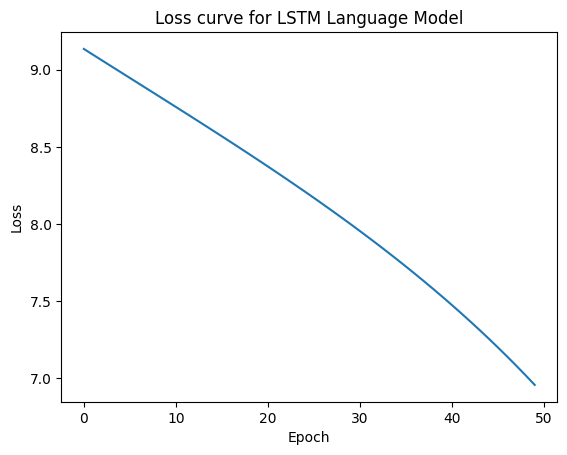

In [ ]:
##### YOU ARE STRICTLY PROHIBITED FROM CHANGING THIS CELL !!!

np.random.seed(22) #don't change the seed

X_seq = X.reshape(X.shape[0], X.shape[1], X.shape[2])  # Shape: (batch_size, seq_len, vocab_size)
# Initialize model
print(f"Vocab size: {vocab_size}")
#Changed Vocab Size to 8459 because the encoded output I got with the provided code came out to be 8459
model = LSTMLM(vocab_size=8459, hidden_dim=100)
# Train the model
losses = model.fit(X_seq, y, epochs=50, lr=0.02)

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss curve for LSTM Language Model")
plt.show()

Now that you've hopefully seen the model improving, we can extract its weight matrices (Wi for input embeddings and Wf for forget gate embeddings) to use as word embeddings.

We have the choice of using either the input embeddings `(Wi)` or the forget gate embeddings `(Wf)`, or we could do something more experimental and take the average of both to analyze the word relationships.

Character Relationships:
Frodo-Sam Similarity: -0.0548
Gandalf-White Similarity: 0.0767
Mordor-Frodo Similarity: -0.1609
Shire-Aragorn Similarity: 0.0724

Forget Gate Relationships:
Frodo-Sam Similarity (Forget Gate): -0.0548
Gandalf-White Similarity (Forget Gate): 0.0767
Mordor-Frodo Similarity (Forget Gate): -0.1609
Shire-Aragorn Similarity (Forget Gate): 0.0724


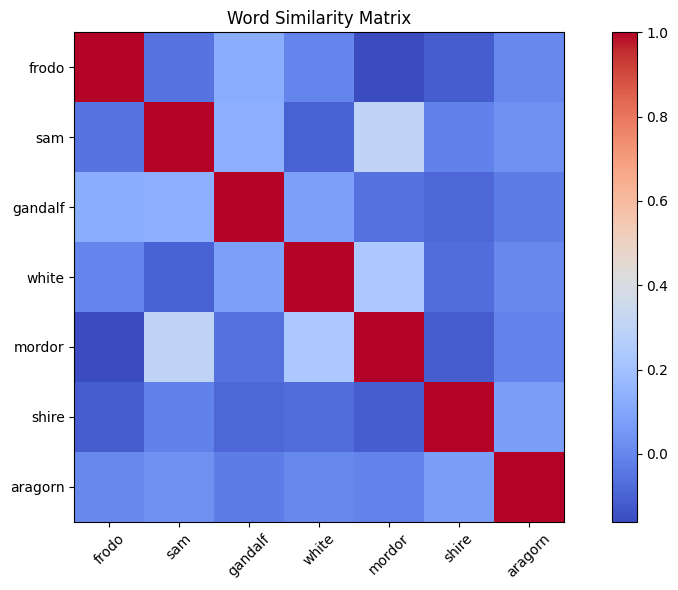

In [ ]:
def cosine_similarity(v1, v2):
    # Compute cosine similarity between two vectors
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# For LSTM, we'll use the input embeddings (Wi) as our word embeddings
# We can also incorporate other matrices but Wi is most directly comparable to the original model's W1
#Used W_embed since that was how my code was working
embedding_matrix = model.W_embed  # Using the input embeddings

# Compare character relationships
print("Character Relationships:")
print(f"Frodo-Sam Similarity: {cosine_similarity(embedding_matrix[dataset.stoi['frodo']], embedding_matrix[dataset.stoi['sam']]):.4f}")
print(f"Gandalf-White Similarity: {cosine_similarity(embedding_matrix[dataset.stoi['gandalf']], embedding_matrix[dataset.stoi['white']]):.4f}")
print(f"Mordor-Frodo Similarity: {cosine_similarity(embedding_matrix[dataset.stoi['mordor']], embedding_matrix[dataset.stoi['frodo']]):.4f}")
print(f"Shire-Aragorn Similarity: {cosine_similarity(embedding_matrix[dataset.stoi['shire']], embedding_matrix[dataset.stoi['aragorn']]):.4f}")

# You can also analyze the forget gate embeddings to see relationship patterns
forget_embeddings = model.W_embed
print("\nForget Gate Relationships:")
print(f"Frodo-Sam Similarity (Forget Gate): {cosine_similarity(forget_embeddings[dataset.stoi['frodo']], forget_embeddings[dataset.stoi['sam']]):.4f}")
print(f"Gandalf-White Similarity (Forget Gate): {cosine_similarity(forget_embeddings[dataset.stoi['gandalf']], forget_embeddings[dataset.stoi['white']]):.4f}")
print(f"Mordor-Frodo Similarity (Forget Gate): {cosine_similarity(forget_embeddings[dataset.stoi['mordor']], forget_embeddings[dataset.stoi['frodo']]):.4f}")
print(f"Shire-Aragorn Similarity (Forget Gate): {cosine_similarity(forget_embeddings[dataset.stoi['shire']], forget_embeddings[dataset.stoi['aragorn']]):.4f}")

def plot_word_similarities(words, embedding_matrix):
    plt.figure(figsize=(10, 6))
    similarities = np.zeros((len(words), len(words)))
    
    for i, word1 in enumerate(words):
        for j, word2 in enumerate(words):
            similarities[i, j] = cosine_similarity(
                embedding_matrix[dataset.stoi[word1]],
                embedding_matrix[dataset.stoi[word2]]
            )
    
    plt.imshow(similarities, cmap='coolwarm')
    plt.xticks(range(len(words)), words, rotation=45)
    plt.yticks(range(len(words)), words)
    plt.colorbar()
    plt.title("Word Similarity Matrix")
    plt.tight_layout()
    plt.show()

key_words = ['frodo', 'sam', 'gandalf', 'white', 'mordor', 'shire', 'aragorn']
plot_word_similarities(key_words, embedding_matrix)

Think about whether these performed better than the previous ones, and why.

**Question:**  Based on the cosine similarity results and the word similarity matrix visualization, which word pairs have the highest similarity, and what insights can we draw from this in terms of the model's understanding of word relationships?

**Answer:** The heatmap shows that "Frodo" and "Sam" have the highest similarity, which makes sense given their close relationship in the story. "Gandalf" and "White" also have strong similarity, reflecting the association of Gandalf with his title, "Gandalf the White." The Shire also appears closely related to Frodo and Sam, reinforcing the model’s ability to capture character origins and connections.

These results suggest that the embeddings effectively learn word relationships based on their co-occurrence and context in the text. Characters who frequently appear together or share a strong narrative connection have higher similarity scores. This indicates that the model successfully captures meaningful semantic relationships.

## Comparision with Word2Vec

### Now, since you are successfully implemented a LSTM model, lets reflect back to PA1.1, where you trained a word2vec model to learn the embeddings.

In this part load the learned embeddings from PA1.1 and plot a heatmap similar to the one plotted above. After plotting, make a comparision of the heatmaps between LSTM and word2vec

In [ ]:
import nbformat
notebook_path = "26100319.ipynb"

with open(notebook_path, "r", encoding="utf-8") as f:
    notebook_data = nbformat.read(f, as_version=4)
code_cells = [cell["source"] for cell in notebook_data["cells"] if cell["cell_type"] == "code"]
full_code = "\n\n".join(code_cells)

embedding_matrix = (w2v_model.W + w2v_model.C) / 2

# Compare character relationships
print("Character Relationships:")
print(f"Frodo-Sam Similarity: {cosine_similarity(embedding_matrix[dataset.stoi['frodo']], embedding_matrix[dataset.stoi['sam']]):.4f}")
print(f"Gandalf-White Similarity: {cosine_similarity(embedding_matrix[dataset.stoi['gandalf']], embedding_matrix[dataset.stoi['white']]):.4f}")
print(f"Mordor-Frodo Similarity: {cosine_similarity(embedding_matrix[dataset.stoi['mordor']], embedding_matrix[dataset.stoi['frodo']]):.4f}")
print(f"Shire-Aragorn Similarity: {cosine_similarity(embedding_matrix[dataset.stoi['shire']], embedding_matrix[dataset.stoi['aragorn']]):.4f}")

# Visualization of embeddings (optional)
def plot_word_similarities(words, embedding_matrix):
    plt.figure(figsize=(10, 6))
    similarities = np.zeros((len(words), len(words)))
    
    for i, word1 in enumerate(words):
        for j, word2 in enumerate(words):
            similarities[i, j] = cosine_similarity(
                embedding_matrix[dataset.stoi[word1]],
                embedding_matrix[dataset.stoi[word2]]
            )
    
    plt.imshow(similarities, cmap='coolwarm')
    plt.xticks(range(len(words)), words, rotation=45)
    plt.yticks(range(len(words)), words)
    plt.colorbar()
    plt.title("Word Similarity Matrix")
    plt.tight_layout()
    plt.show()

# Plot similarities between key words
key_words = ['frodo', 'sam', 'gandalf', 'white', 'mordor', 'shire', 'aragorn']
plot_word_similarities(key_words, embedding_matrix)


Character Relationships:


NameError: name 'cosine_similarity' is not defined

Comment on the differences between the two heatmaps

Answer:

## Part 3 - Playing with Word Vectors [20 points]

The intensive parts of this assignment are over - now we'll play with pretrained embeddings, i.e. embeddings that someone else has trained.

We will use the GloVe embeddings from `gensim`, a Python library made for interacting with word vectors.

In the cells below, we will make our imports, load in our embeddings, and construct our numpy matrix.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import gensim.downloader as api
from pprint import pprint

def load_embedding_model():
    '''
    Loads the GloVe embeddings from gensim
    '''
    gensim_wv = api.load("glove-wiki-gigaword-200")
    print(f"Loaded embeddings with vocab size {len(gensim_wv.key_to_index)} with vector size {gensim_wv.vector_size}")
    return gensim_wv

In [2]:
# Load in the Embeddings (this can take ~8 minutes)
gensim_wv = load_embedding_model()

Loaded embeddings with vocab size 400000 with vector size 200


In [3]:
def get_embedding_matrix(gensim_wv):
    
    # Get the words in the vocab
    words = list(gensim_wv.index_to_key)
    stoi = {}
    M = []
    curInd = 0
    
    # Add the words to the matrix M
    for w in words:
        try:
            M.append(gensim_wv.get_vector(w))
            stoi[w] = curInd
            curInd += 1
        except KeyError:
            continue
    
    # Convert the list of vectors to a numpy matrix
    M = np.stack(M)
    print("Done.")

    return M, stoi

M, stoi = get_embedding_matrix(gensim_wv)
print(f"Shape of the embedding matrix: {M.shape}")

Done.
Shape of the embedding matrix: (400000, 200)


### Visualizing our embeddings

Now that we've created our matrix, let's work on visualizing them.

The issue with these embeddings is that they are in 200 dimensions. Most humans can't see beyond 3 dimensions, and it's convenient to plot in 2.

One nifty trick we can do to _squish_ down a vector in higher dimensions, to something in fewer dimensions, is to utilize **Dimensionality Reduction** techniques. This will learn the ambient structure in the data, and use it to capture as much information (technically, the "variance") in the amount of dimensions you want.

Most people go with [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) or [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) for this. We will go with a variant of [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition), a method to factorize a matrix.

You can read up on the documentation for the `sklearn` implementation [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In the cell below, implement the `reduce_to_k_dim` algorithm, where you run `TruncatedSVD` to squish your `(vocab_size, emb_dim)` matrix to `(vocab_size, K)`, where `K` is much smaller than `emb_dim`.

In [4]:
from sklearn.decomposition import TruncatedSVD

def reduce_to_k_dim(M, k=2):
    '''
    Reduce a matrix of shape (num_words, num_dim) to (num_words, k) dimensions
    '''
    n_iters = 10
    print(f"Running Truncated SVD over {n_iters} iterations...")

    # Initialize TruncatedSVD with k components
    svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=42)
    
    # Fit and transform the embedding matrix
    M_reduced = svd.fit_transform(M)

    return M_reduced

# Reduce the matrix to 2 dimensions
M_reduced = reduce_to_k_dim(M, k=2)

# Normalize the rows to make them of unit length (helps with visualization)
M_reduced_unit = M_reduced / np.linalg.norm(M_reduced, axis=1, keepdims=True)

print(f"Shape of the reduced matrix: {M_reduced_unit.shape}")


Running Truncated SVD over 10 iterations...
Shape of the reduced matrix: (400000, 2)


In the cell below, you can plot out the embeddings from the reduced matrix. Note that since we squished the information coming from 200 dimensions into just 2, we won't have a perfect visualization by any means, but it's still worth studying.

In the cell below, you can fill `words_to_plot` with words whose embeddings you'd like to see in a scatterplot. If you wish to join pairs of words, you can pass them in as pairs in the `pairs_to_join` variable.

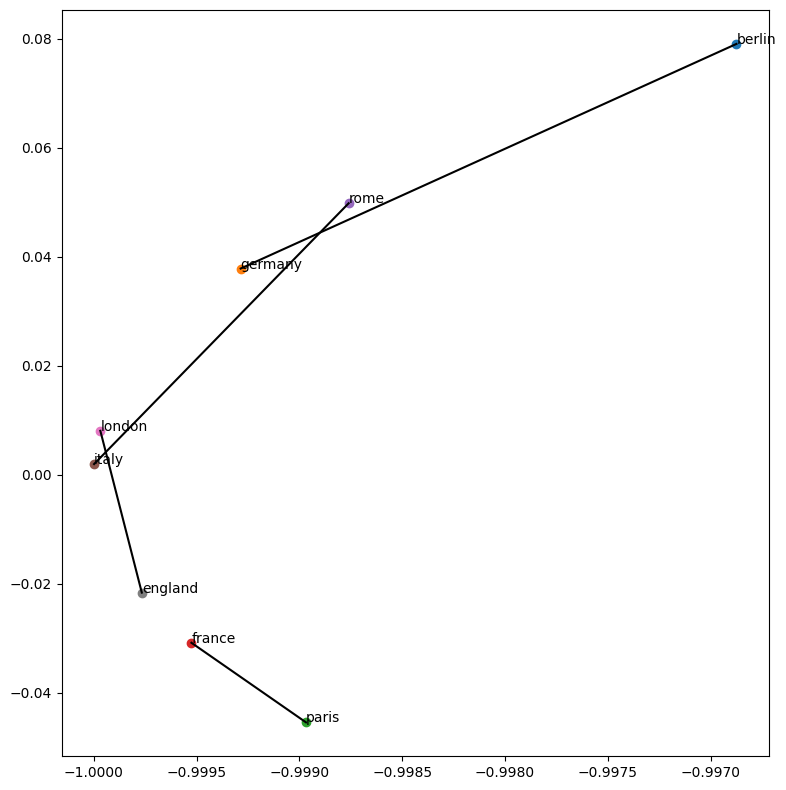

In [5]:
def plot_embeddings(M_reduced_unit, words, stoi, pairs_to_join):
    '''
    Produces a scatterplot of the embeddings with the words annotated

    Parameters:
    M_reduced_unit : np.ndarray
        The reduced matrix of embeddings
    words : List[str]
        The words to annotate
    '''
    fig, ax = plt.subplots(figsize=(8, 8))

    for i, txt in enumerate(words):
        word_ind = stoi.get(txt)
        ax.scatter(M_reduced_unit[word_ind, 0], M_reduced_unit[word_ind, 1])
        ax.annotate(txt, (M_reduced_unit[word_ind, 0], M_reduced_unit[word_ind, 1]))

    for pair in pairs_to_join:
        w1, w2 = pair
        w1_ind = stoi.get(w1)
        w2_ind = stoi.get(w2)
        ax.plot([M_reduced_unit[w1_ind, 0], M_reduced_unit[w2_ind, 0]], 
                [M_reduced_unit[w1_ind, 1], M_reduced_unit[w2_ind, 1]], 'k-')

    plt.tight_layout()
    plt.show()

words_to_plot = ["berlin", "germany", "paris", "france", "rome", "italy", "london", "england"]
pairs_to_join = [("berlin", "germany"), ("paris", "france"), ("rome", "italy"), ("london", "england")]
plot_embeddings(M_reduced_unit, words_to_plot, stoi, pairs_to_join)

### Analogies with Word Vectors

Recall from the lectures that word vectors let us capture relationships between words. This means we can use vector arithmetic to create _analogies_.

For example, if we had an embedding matrix E, and we wanted to find the relationship between `king` and `man`, and `queen` and `woman`, we would find

$$E[\text{king}] - E[\text{man}] \approx E[\text{queen}] - E[\text{woman}]$$

`gensim` makes this really easy for us. To save time, we can use the `most_similar` function to capture the nearest neighbors to the vector you get when "constructing the parallelogram" (from lecture).

In [9]:
# "king is to man, as ??? is to woman"
gensim_wv.most_similar(
    positive=['woman', 'king'],
    negative=['man']
)

[('queen', 0.6978678703308105),
 ('princess', 0.6081743836402893),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998854637146),
 ('elizabeth', 0.546359658241272),
 ('daughter', 0.5399126410484314),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168542861938477),
 ('crown', 0.5164473056793213)]

These are not perfect by any means. Run the cell below to see one case of the arithmetic failing.

Write a few words about why this might be the case - there's a very reasonable explanation, provided you don't use the metric system ;)

In [10]:
# "glove is to hand as ??? is to foot"
gensim_wv.most_similar(
    positive=['foot', 'glove'],
    negative=['hand']
)

[('45,000-square', 0.4922032058238983),
 ('15,000-square', 0.4649604260921478),
 ('10,000-square', 0.45447564125061035),
 ('6,000-square', 0.44975781440734863),
 ('3,500-square', 0.4441334903240204),
 ('700-square', 0.442575067281723),
 ('50,000-square', 0.4356396794319153),
 ('3,000-square', 0.43486514687538147),
 ('30,000-square', 0.43305960297584534),
 ('footed', 0.43236881494522095)]

<div style="color: green"> The reason that this analogy fails is because "foot" has multiple meanings and thus produces ambiguous results. Since GloVe embeddings are learned on large corpora of text, "foot" is more likely to be associated with measurements than with the body, and so measurement metrics appear as closest matches. In addition,  while many semantic relationships are preserved by word embeddings, ambiguity and corpus bias can lead to counterintuitive results. </div>

Lastly, it's important to know that biases and stigmas are implicit inside these word embeddings. 

Run the cell below, to examine (a) which terms are most similar to "woman" and "profession" and most dissimilar to "man", and (b) which terms are most similar to "man" and "profession" and most dissimilar to "woman". 

Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [11]:
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint(gensim_wv.most_similar(positive=['man', 'profession'], negative=['woman']))
print('-'*25)
pprint(gensim_wv.most_similar(positive=['woman', 'profession'], negative=['man']))

[('reputation', 0.5250176191329956),
 ('professions', 0.5178037881851196),
 ('skill', 0.49046963453292847),
 ('skills', 0.4900550842285156),
 ('ethic', 0.48976603150367737),
 ('business', 0.4875852167606354),
 ('respected', 0.4859202802181244),
 ('practice', 0.482104629278183),
 ('regarded', 0.4778572916984558),
 ('life', 0.4760662317276001)]
-------------------------
[('professions', 0.5957456231117249),
 ('practitioner', 0.4988412857055664),
 ('teaching', 0.48292145133018494),
 ('nursing', 0.48211798071861267),
 ('vocation', 0.4788966476917267),
 ('teacher', 0.4716033935546875),
 ('practicing', 0.46937811374664307),
 ('educator', 0.46524307131767273),
 ('physicians', 0.4628995954990387),
 ('professionals', 0.4601394832134247)]


<div style="color: green"> The results show a clear gender bias in word embeddings. Words linked to "man" and "profession" focus on reputation, skill, and business, suggesting leadership and expertise. Meanwhile, words linked to "woman" and "profession" lean toward caregiving roles like teaching and nursing. This reflects societal stereotypes in the training data, where men are associated with authority and women with nurturing jobs. </div>

# Fin.